In [29]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# def optimize_power_schedule(e, V, dt, max_total_energy, num_evs, num_time_steps):
#     """
#     Optimize the power schedule for EV charging with a maximum total available energy constraint.

#     Parameters:
#     e : ndarray
#         A 1D array where e[i] represents the total energy requested by EV i.
#     V : float
#         The charging voltage (e.g., 240V for Level-2 chargers).
#     dt : float
#         Time step duration in hours.
#     max_total_energy : float
#         Maximum total available energy (kWh).
#     num_evs : int
#         Number of EVs.
#     num_time_steps : int
#         Number of time steps.

#     Returns:
#     ndarray
#         Optimized charging schedule (r).
#     """
#     # Decision variable: charging current for each EV at each time step
#     r = cp.Variable((num_evs, num_time_steps), nonneg=True)

#     # Compute delivered energy for each EV
#     delivered_energy = cp.sum(r, axis=1) * V * dt

#     # Compute energy deviation for each EV
#     energy_deviation = delivered_energy - e

#     # Objective function: minimize the sum of squared energy deviations
#     objective = cp.Minimize(cp.sum_squares(energy_deviation))

#     # Constraints
#     constraints = [
#         cp.sum(r) * V * dt <= max_total_energy,  # Total energy constraint
#         delivered_energy <= e  # Do not exceed requested energy
#     ]

#     # Define and solve the problem
#     problem = cp.Problem(objective, constraints)
#     problem.solve()

#     return r.value




In [47]:
def optimize_power_schedule(e, V, dt, max_total_energy, num_evs, num_time_steps, fast_charge_weight=0.1):
    # Decision variable: charging current for each EV at each time step
    r = cp.Variable((num_evs, num_time_steps), nonneg=True)

    # Compute delivered energy for each EV
    delivered_energy = cp.sum(r, axis=1) * V * dt

    # Compute energy deviation for each EV
    energy_deviation = delivered_energy - e

    # Combined objective function
    objective = cp.Minimize(cp.sum_squares(energy_deviation))

    # Constraints
    constraints = [
        cp.sum(r) * V * dt <= max_total_energy,  # Total energy constraint
        delivered_energy <= e  # Do not exceed requested energy
    ]

    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return r.value


In [48]:
# Example usage
num_evs = 5
num_time_steps = 6
e = np.array([20, 15, 25, 30, 10])  # Energy requests in kWh
V = 240  # Charging voltage in Volts
dt = 0.5  # Time step duration in hours
max_total_energy = 100  # Maximum total available energy in kWh

optimized_schedule = optimize_power_schedule(e, V, dt, max_total_energy, num_evs, num_time_steps)

print("Optimized Charging Schedule:")
print(optimized_schedule)

# Calculate and print the actual delivered energy
delivered_energy = np.sum(optimized_schedule, axis=1) * V * dt
print("\nDelivered Energy (kWh):")
print(delivered_energy)

print("\nRequested Energy (kWh):")
print(e)

print(f"\nTotal Energy Used: {np.sum(delivered_energy):.2f} kWh")
print(f"Maximum Total Energy: {max_total_energy} kWh")

Optimized Charging Schedule:
[[0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
 [0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333]
 [0.03472222 0.03472222 0.03472222 0.03472222 0.03472222 0.03472222]
 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
 [0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889]]

Delivered Energy (kWh):
[20. 15. 25. 30. 10.]

Requested Energy (kWh):
[20 15 25 30 10]

Total Energy Used: 100.00 kWh
Maximum Total Energy: 100 kWh


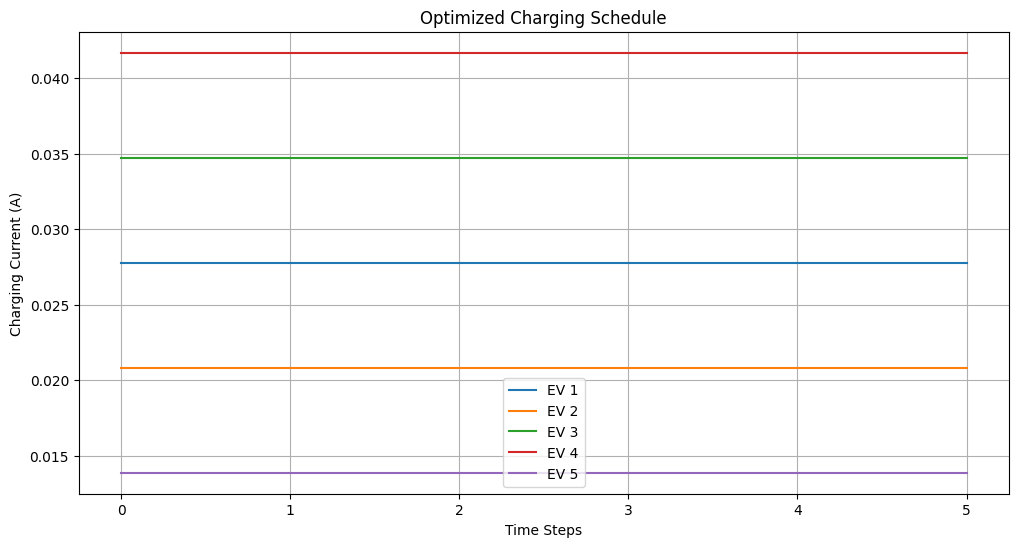

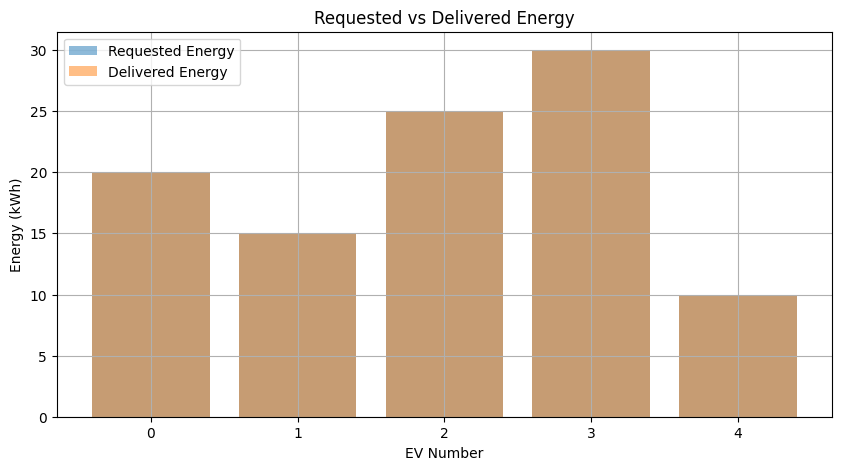

In [49]:
# Visualize the charging schedule
plt.figure(figsize=(12, 6))
for i in range(num_evs):
    plt.plot(range(num_time_steps), optimized_schedule[i], label=f'EV {i+1}')


plt.xlabel('Time Steps')
plt.ylabel('Charging Current (A)')
plt.title('Optimized Charging Schedule')
plt.legend()
plt.grid(True)
plt.show()

# Visualize energy delivery
plt.figure(figsize=(10, 5))
plt.bar(range(num_evs), e, alpha=0.5, label='Requested Energy')
plt.bar(range(num_evs), delivered_energy, alpha=0.5, label='Delivered Energy')
plt.xlabel('EV Number')
plt.ylabel('Energy (kWh)')
plt.title('Requested vs Delivered Energy')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

def optimize_charging_schedule(num_evs, num_time_steps, e, arrival_times, departure_times, max_power, dt=0.25, voltage=240):
    """
    Optimizes the charging schedule for multiple electric vehicles (EVs).

    Args:
        num_evs (int): The number of electric vehicles.
        num_time_steps (int): The number of time steps (e.g., 24 for a 24-hour period).
        e (np.array): An array of energy requests (kWh) for each EV.
        arrival_times (np.array): An array of arrival times for each EV (in time steps).
        departure_times (np.array): An array of departure times for each EV (in time steps).
        max_power (float): The maximum available power in kW.
        dt (float, optional): Duration of each time step in hours (default 0.25 for 15-minute intervals).
        voltage (float, optional): The voltage for charging (default 240V).

    Returns:
        np.array: The optimized charging current schedule for each EV at each time step.
    """
    # Discrete current levels in amperes
    current_levels = np.array([0, 8, 16, 32, 48, 64])
    
    # Decision variables: x[i, t, c] means EV i at time t and current level c
    x = cp.Variable((num_evs, num_time_steps, len(current_levels)), boolean=True)
    
    # Ensure that the current_levels array aligns with the third axis of the decision variable x
    # Calculate charging current for each EV at each time step
    r = cp.sum(cp.multiply(x, current_levels), axis=2)  # Sum of current for each EV at each time step
    
    # Compute the delivered energy in kWh
    delivered_energy = cp.sum(r, axis=1) * voltage * dt / 1000  # Convert to kWh
    
    # Objective function: minimize energy deviation and incentivize fast charging
    energy_deviation = delivered_energy - e
    time_penalty = np.arange(num_time_steps).reshape(1, -1, 1)  # Time penalty to encourage fast charging
    objective = cp.Minimize(cp.sum_squares(energy_deviation) + 0.1 * cp.sum(cp.multiply(x, time_penalty)))
    
    # Constraints
    constraints = [
        cp.sum(r, axis=0) * voltage / 1000 <= max_power,  # Maximum power constraint in kW
        delivered_energy <= e,                            # Do not exceed requested energy
        cp.sum(x, axis=2) == 1                            # Only one current level selected per EV per time step
    ]
    
    # Time constraints for each EV (no charging before arrival or after departure)
    for i in range(num_evs):
        if arrival_times[i] > 0:
            constraints.extend([x[i, t, :] == 0 for t in range(arrival_times[i])])  # No charging before arrival
        if departure_times[i] < num_time_steps:
            constraints.extend([x[i, t, :] == 0 for t in range(departure_times[i], num_time_steps)])  # No charging after departure
    
    # Solve the problem using an alternative solver (GUROBI or another available solver)
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.GUROBI)  # Use GUROBI solver
    except cp.SolverError as e:
        print(f"Solver error: {e}")
        return None
    
    # Check if the solution is optimal
    if problem.status != cp.OPTIMAL:
        print(f"Optimization failed: {problem.status}")
        return None
    
    return r.value  # Return the optimized charging current for each EV

# Example usage
num_evs = 5
num_time_steps = 24  # 6 hours with 15-minute intervals (96 steps for a full day)
e = np.array([20, 15, 25, 30, 10])  # Energy requests in kWh for each EV
arrival_times = np.array([0, 2, 4, 1, 3])  # Arrival times for each EV (in time steps)
departure_times = np.array([20, 18, 22, 23, 15])  # Departure times for each EV (in time steps)
max_power = 50  # Maximum power in kW

# Optimize the charging schedule
optimized_schedule = optimize_charging_schedule(num_evs, num_time_steps, e, arrival_times, departure_times, max_power)

# Plot the results if the optimization was successful
if optimized_schedule is not None:
    plt.figure(figsize=(12, 6))
    for i in range(num_evs):
        plt.step(range(num_time_steps), optimized_schedule[i], label=f'EV {i+1}', where='post')
        plt.axvline(x=arrival_times[i], color='g', linestyle='--', alpha=0.5, label=f'Arrival EV {i+1}')
        plt.axvline(x=departure_times[i], color='r', linestyle='--', alpha=0.5, label=f'Departure EV {i+1}')

    plt.xlabel('Time Steps (15-minute intervals)')
    plt.ylabel('Charging Current (A)')
    plt.title('Optimized Charging Schedule')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid(True)

    # Plot total power consumption on a second y-axis
    total_power = np.sum(optimized_schedule, axis=0) * 240 / 1000  # Convert to kW
    plt.twinx()
    plt.plot(range(num_time_steps), total_power, 'k--', label='Total Power Consumption')
    plt.ylabel('Total Power (kW)')
    plt.axhline(y=max_power, color='r', linestyle=':', label='Max Power')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


ValueError: inconsistent shapes